# 0.0 IMPORTS

In [79]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime
from tabulate import tabulate
from scipy import stats as ss


## 0.1 Helper Functions

In [2]:
# Display

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 6]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# V de Cramer

def v_cramer(x,y):
    
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    k, r = cm.shape
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv')
df_stores_raw = pd.read_csv('data/store.csv')

/Users/macuser/.pyenv/versions/3.8.0/envs/DsEmProducao/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old)) # faz o mapeamento da funcao 'snakecase' em todas os elementos da lista

#rename

df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes # Object eh o caractere dentro do pandas

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NAs

In [11]:
df1.isna().sum() # mostra todas as linhas que tem pelo menos uma coluna NA

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA


In [12]:
#competition_distance             
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: 
                                                x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                                else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: 
                                                x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                                else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                                                else x['promo2_since_week'], axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                                                else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else
                                                                        1 if x['month_map'] in x['promo_interval'].split(',') 
                                                                          else 0, axis=1)

## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
df1['state_holiday'] = df1['state_holiday'].astype(str)

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [ ]:
num_attributes

## 1.7.1 Numerical Attributes

In [15]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean))
ct2 = pd.DataFrame(num_attributes.apply(np.median))

# Dispersion - std, min, max, range, skew, kurtosis
dt1 = pd.DataFrame(num_attributes.apply(np.std))
dt2 = pd.DataFrame(num_attributes.apply(np.min))
dt3 = pd.DataFrame(num_attributes.apply(np.max))
dt4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()))
dt5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
dt6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))

# Concatenate
m = pd.concat([dt2, dt3, dt4, ct1, ct2, dt1, dt5, dt6], axis=1).reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [16]:
cat_attributes.sample(10)

,state_holiday,store_type,assortment,promo_interval,month_map
805568,0,a,c,"Jan,Apr,Jul,Oct",Jul
478505,0,a,a,"Feb,May,Aug,Nov",Apr
799094,0,d,c,0,Jul
843614,0,a,a,"Jan,Apr,Jul,Oct",Jun
528419,0,a,a,"Jan,Apr,Jul,Oct",Mar
687285,0,a,a,0,Oct
551640,0,a,c,0,Feb
475532,a,d,c,"Jan,Apr,Jul,Oct",May
58772,0,d,a,0,Jun
89457,0,a,a,"Jan,Apr,Jul,Oct",May


In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

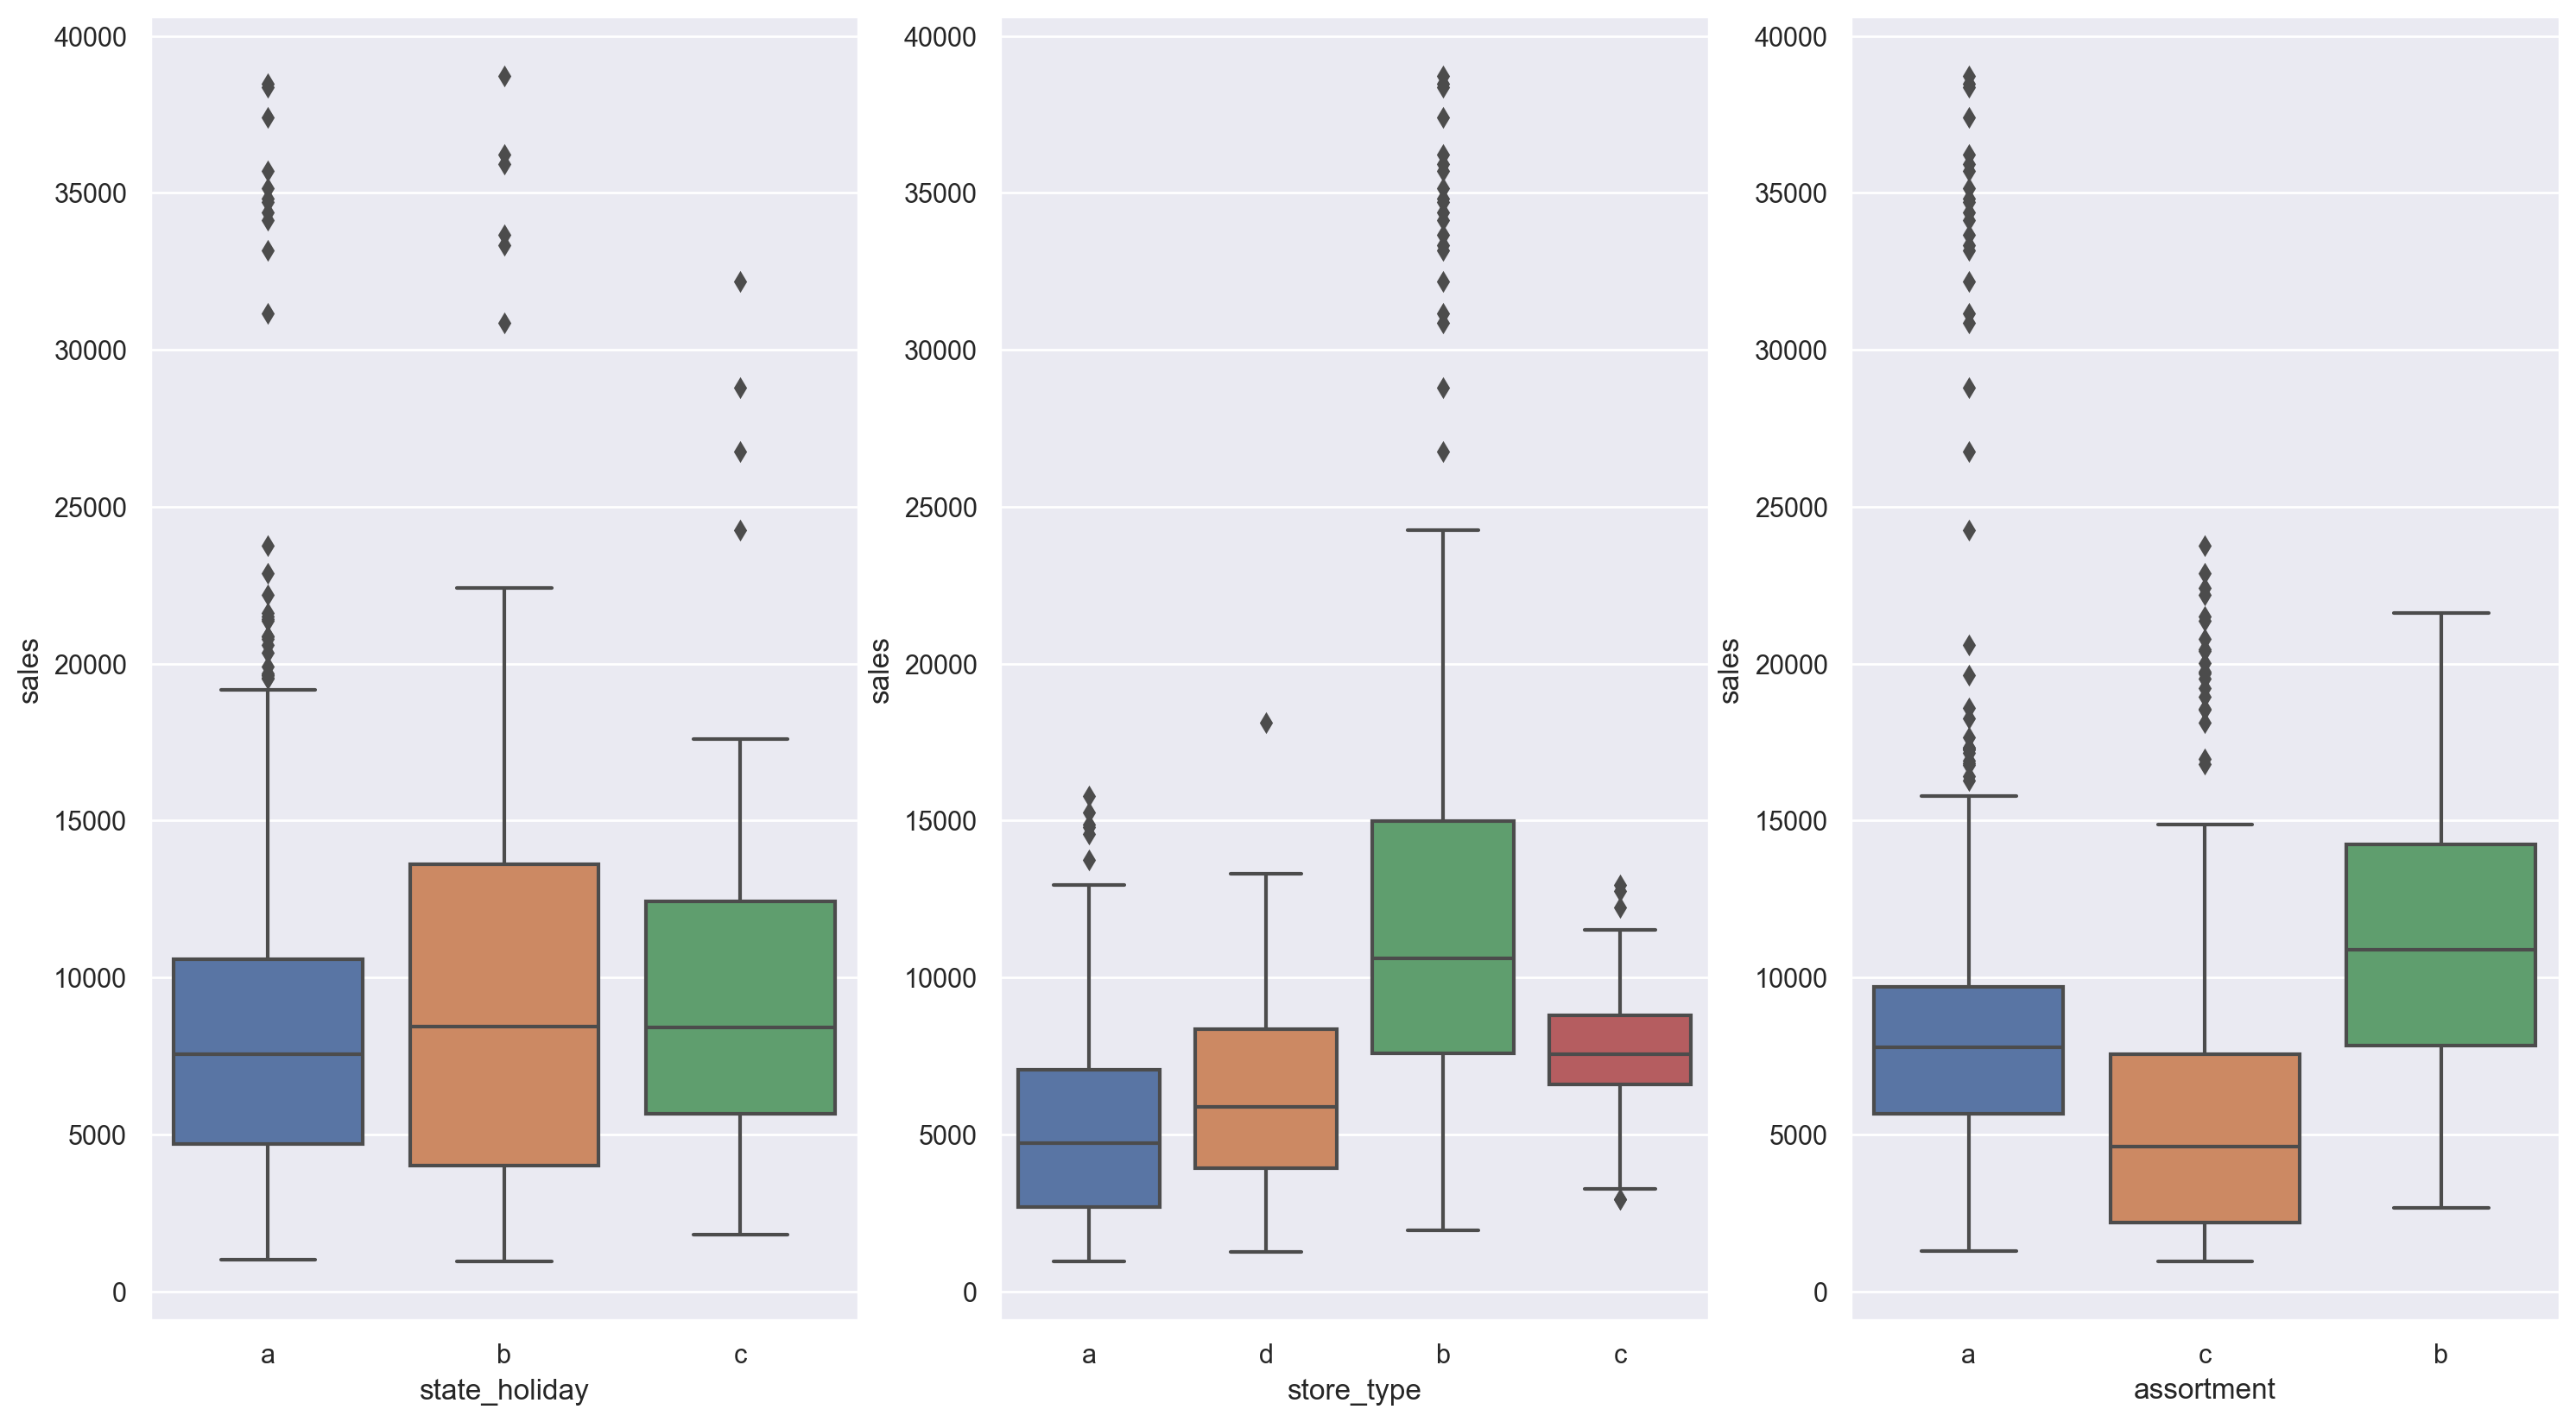

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(18, 10), dpi= 200, facecolor='w', edgecolor='k')

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 Mind Map Hypotesis

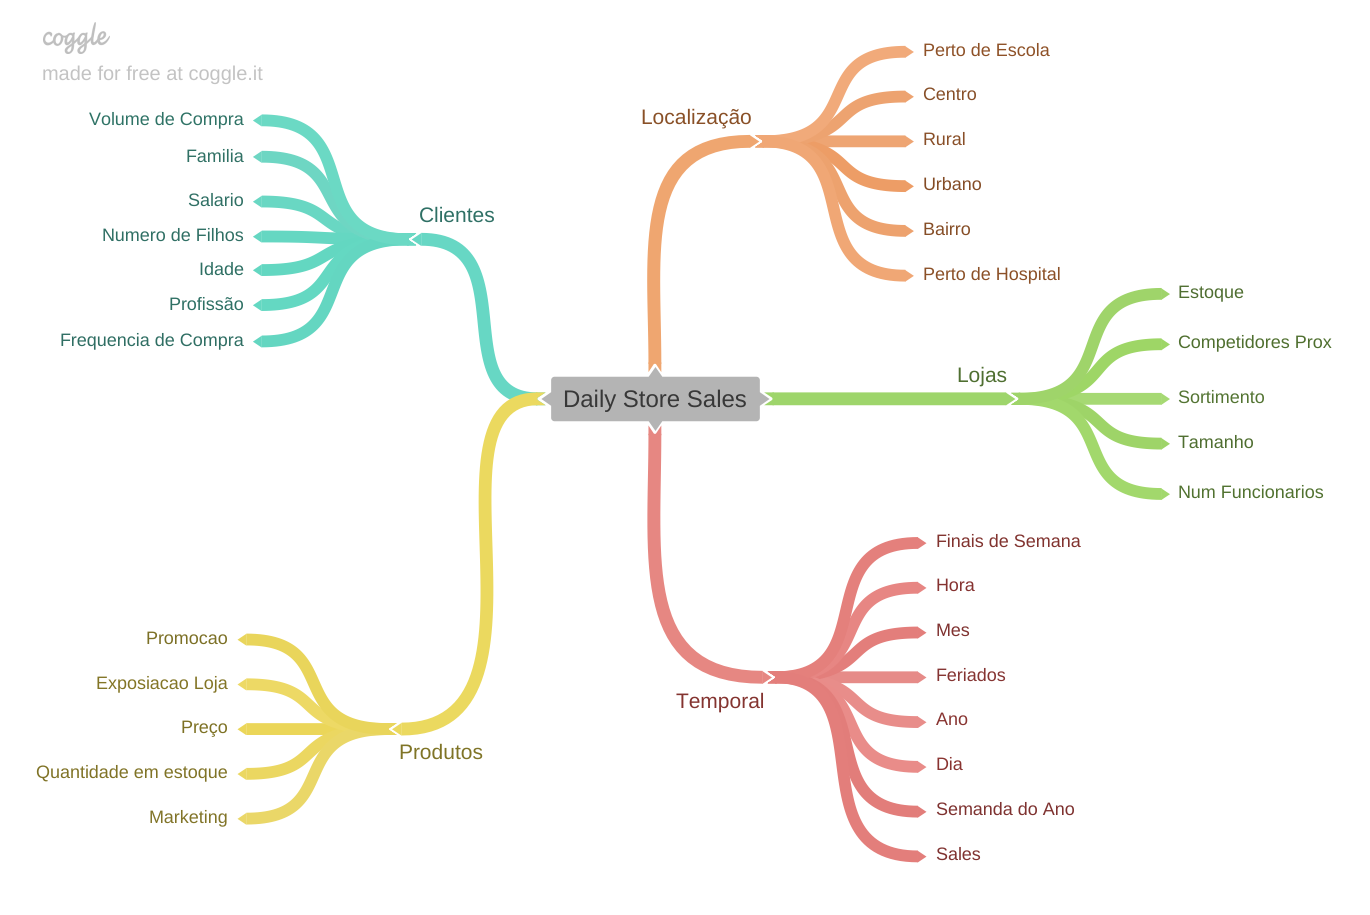

In [20]:
Image('images/MindMapHypothesis.png')

## 2.2 Hypothesis Creation

### 2.2.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionarios deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveria vender mais

**5.** Lojas com competidores mais proximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais



### 2.2.2 Product Hypothesis

**1.** Lojas que investem mais em mkt deveriam vender mais

**2.** Lojas com maior exposicao de produtos deveriam vender mais

**3.** Lojas com produtos mais baratos deveriam vender mais

**4.** Lojas com promocoes mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com mais dias em promocao deveriam vender mais

**6.** Lojas com mais promocoes consecutivas deveriam vender mais

### 2.2.3 Temporal Hypothesis

**1.** Lojas abertas durante o feriado de Natal, deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas deveriam vender mais depois do dia 10 de cada mes

**5.** Lojas deveriam vender menos aos finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Final Hypothesis List

**1.** Lojas com maior sortimento deveria vender mais

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promocoes mais agressivas (descontos maiores) deveriam vender mais

**5.** Lojas com mais dias em promocao deveriam vender mais

**6.** Lojas com mais promocoes consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal, deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering - Derivar variaveis

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )


#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply((lambda x: 'public_holiday' if x == 'a' else
                                                             'easter_holiday' if x == 'b' else
                                                             'christmas' if x == 'c' else
                                                             'regular_day'))


<ipython-input-21-f18e46cd411e>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VAR FILTERS

In [23]:
df3 = df2.copy()

In [24]:
df3[(df3['open'] == 0) & (df3['sales'] > 0)]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week


## 3.1 Row Filters

In [25]:
df3 = df3.loc[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Cols Selection

In [26]:
df3 = df3.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1)

In [27]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATION DATA ANALYSIS

In [28]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

/Users/macuser/.pyenv/versions/3.8.0/envs/DsEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

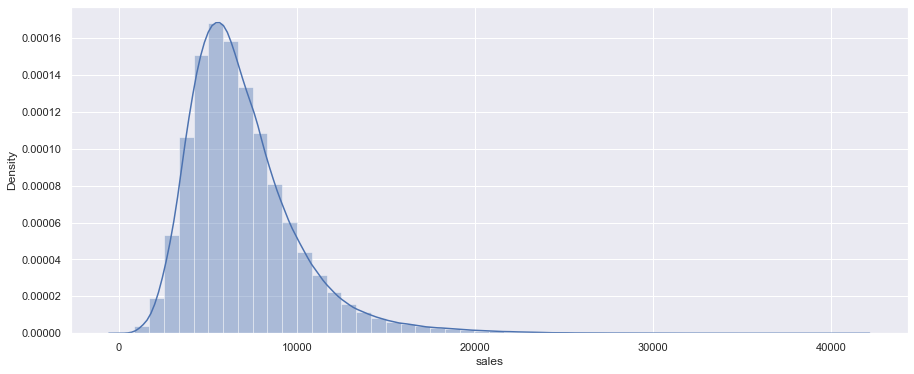

In [29]:
sns.distplot(df4['sales']) #densidade de distribuicao, nao eh o histograma -> kde=False

### 4.1.1 Numerical Variables

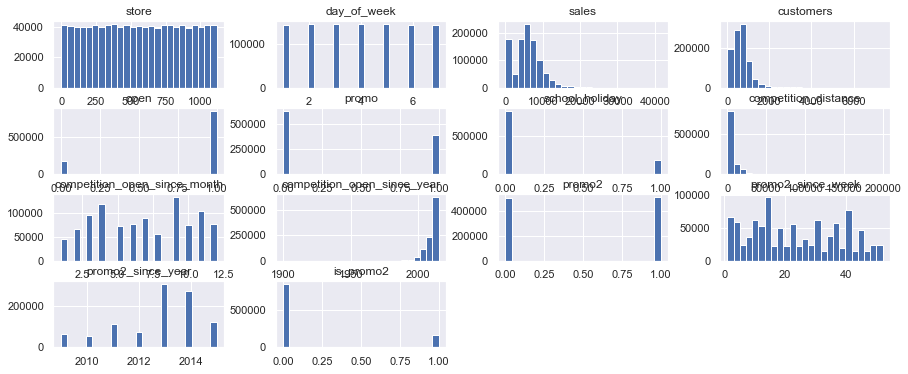

In [30]:
num_attributes.hist(bins=25);

### 4.1.1 Categorial Variables

In [31]:
cat_attributes = cat_attributes.drop(['promo_interval', 'month_map'], axis=1)
cat_attributes.head()


,state_holiday,store_type,assortment
0,0,c,a
1,0,a,a
2,0,a,a
3,0,c,c
4,0,a,a


In [32]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/Users/macuser/.pyenv/versions/3.8.0/envs/DsEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/macuser/.pyenv/versions/3.8.0/envs/DsEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/macuser/.pyenv/versions/3.8.0/envs/DsEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wi

<AxesSubplot:xlabel='sales', ylabel='Density'>

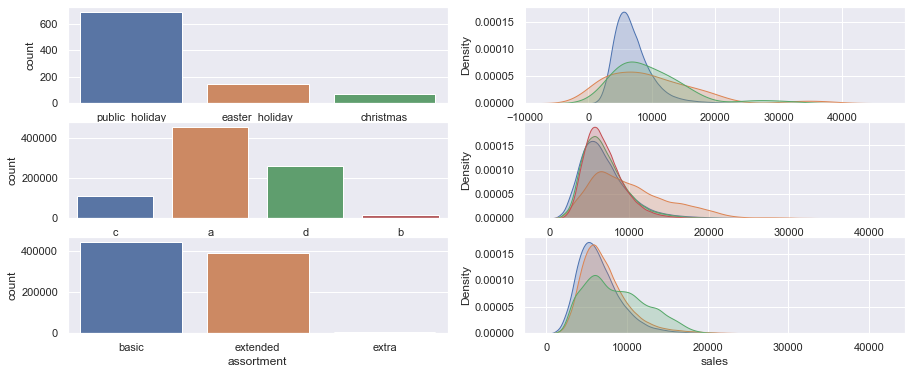

In [33]:
# state_holiday

aux1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3,2,1)

sns.countplot(aux1['state_holiday'])

plt.subplot(3,2,2)

sns.kdeplot(df4[df4['state_holiday'] == 'regular_day']['sales'], legend=True, shade=True, label='regular_day')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], legend=True, shade=True, label='easter_holiday')
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], legend=True, shade=True, label='christmas')

# store type

plt.subplot(3,2,3)

sns.countplot(df4['store_type'])

plt.subplot(3,2,4)

sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade=True, label='a')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade=True, label='b')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade=True, label='c')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade=True, label='d')

#assortment

plt.subplot(3,2,5)

sns.countplot(df4['assortment'])

plt.subplot(3,2,6)

sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade=True, label='extended')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True, label='extra')


## 4.2 Bivariate Analysis

### H1. Lojas com maior sortimento deveria vender mais
***FALSE***: Lojas com maior sortimento vendem menos



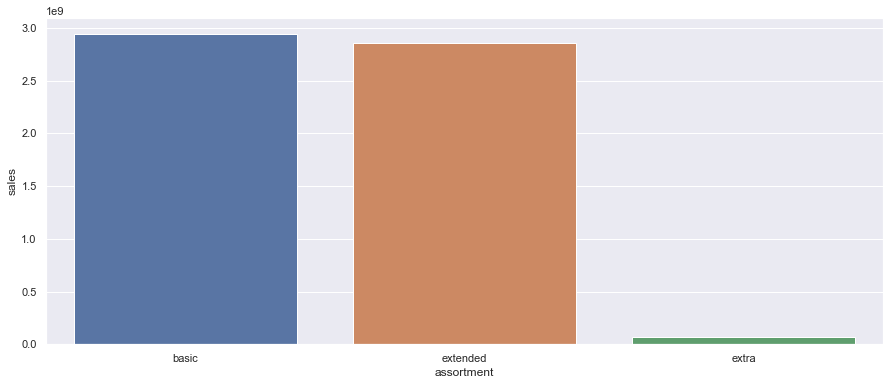

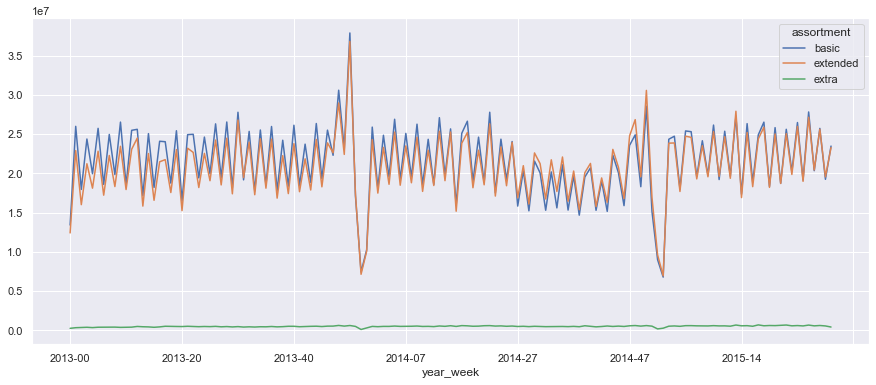

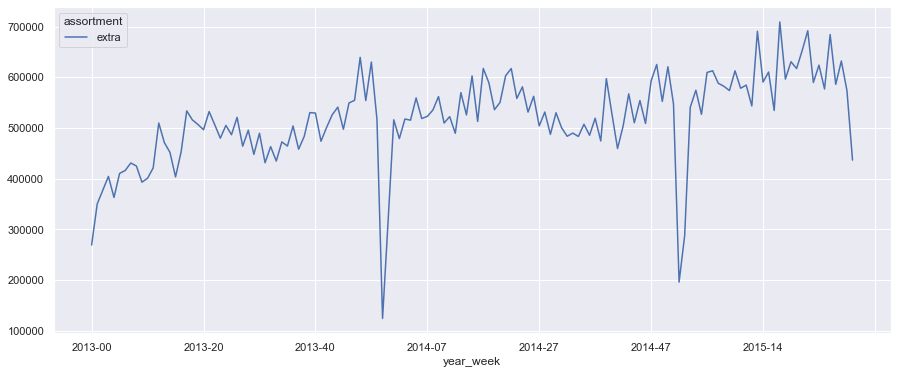

In [34]:
aux2 = df4[['sales', 'assortment']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment', y='sales', data=aux2);

aux3 = df4[['sales', 'assortment', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()

aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

aux4 = aux3[aux3['assortment']=='extra']

aux4.pivot(index='year_week', columns='assortment', values='sales').plot();


### H2. Lojas com competidores mais proximos deveriam vender menos
***FALSE***: Lojas com competidores mais proximos vendem mais

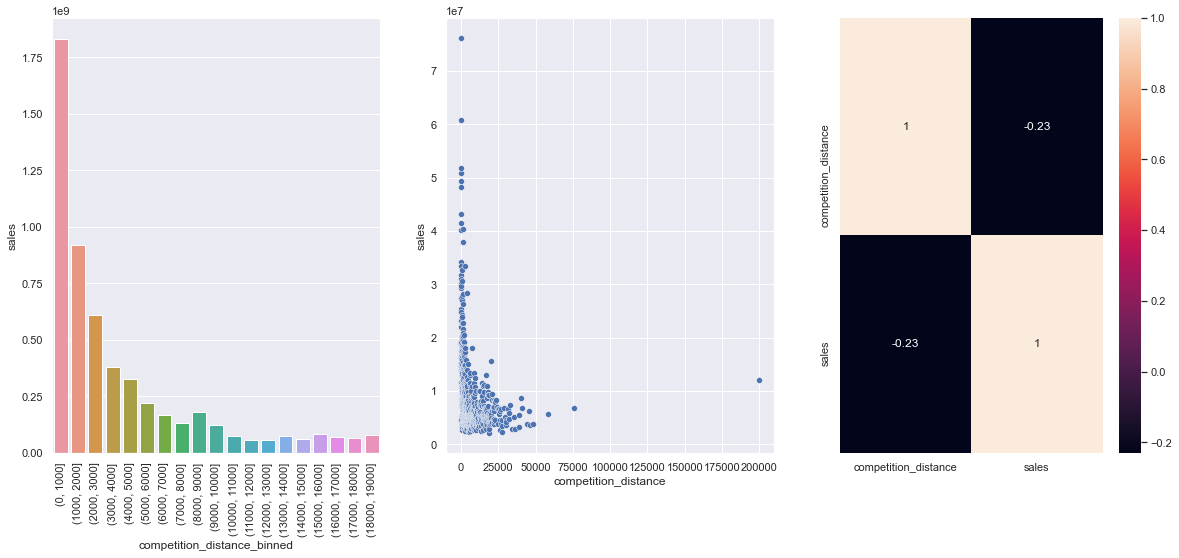

In [35]:
aux5 = df4[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux5['competition_distance_binned'] = pd.cut(aux5['competition_distance'], bins=bins)

aux5 = aux5[['sales', 'competition_distance_binned']].groupby('competition_distance_binned').sum().reset_index()


figsize(20, 8)


plt.subplot(1,3,1)

sns.barplot(x='competition_distance_binned', y='sales', data=aux5);
plt.xticks(rotation=90)

plt.subplot(1,3,2)

aux6 = df4[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x='competition_distance', y='sales', data=aux6);

plt.subplot(1,3,3)
sns.heatmap(aux6.corr(method='pearson'), annot=True);


### H3. Lojas com competidores a mais tempo deveriam vender mais
***FALSE***: Lojas com competidores a mais tempo vendem menos

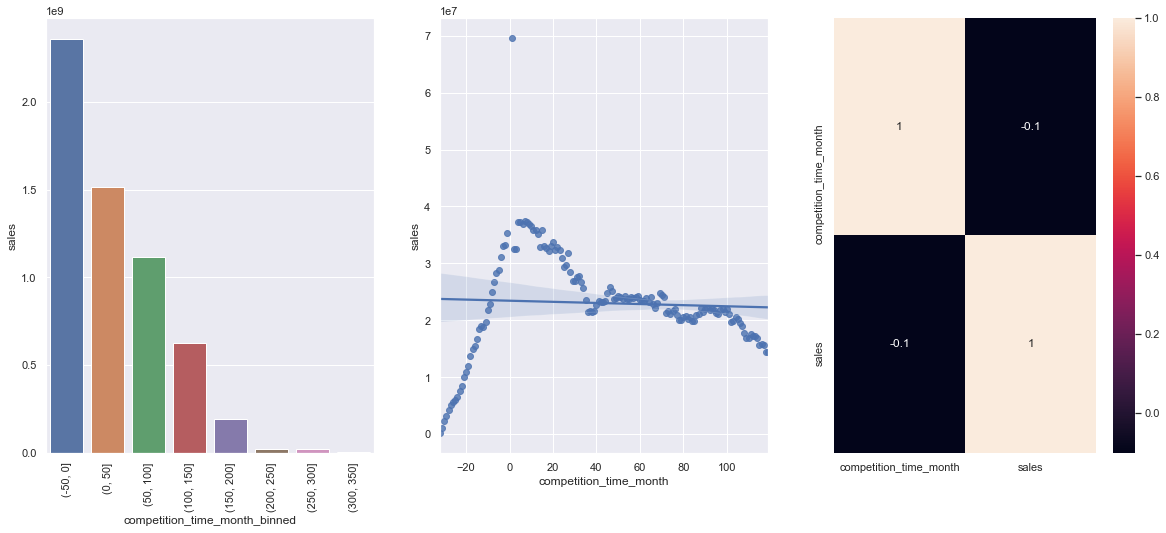

In [36]:
aux7 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').sum().reset_index()

bins = list(np.arange(-50, 400, 50))

aux7['competition_time_month_binned'] = pd.cut(aux7['competition_time_month'], bins=bins)

aux8 = aux7[['sales', 'competition_time_month_binned']].groupby('competition_time_month_binned').sum().reset_index()

figsize(20, 8)

plt.subplot(1,3,1)

sns.barplot(x='competition_time_month_binned', y='sales', data=aux8);
plt.xticks(rotation=90);

plt.subplot(1,3,2)

aux9 = aux7[(aux7['competition_time_month'] < 120) & (aux7['competition_time_month'] != 0)]

sns.regplot(x='competition_time_month', y='sales', data=aux9, scatter=True, fit_reg=True)

plt.subplot(1,3,3)
sns.heatmap(aux7.corr(method='pearson'), annot=True);





### H4. Lojas com promocoes ativas por mais tempo deveriam vender mais
***FALSE***: promocoes aumentam as vendas por um tempo, mas depois caem

<ipython-input-37-279db68d5ca6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux11['promo_time_week_binned'] = pd.cut(aux10['promo_time_week'], bins=bins)


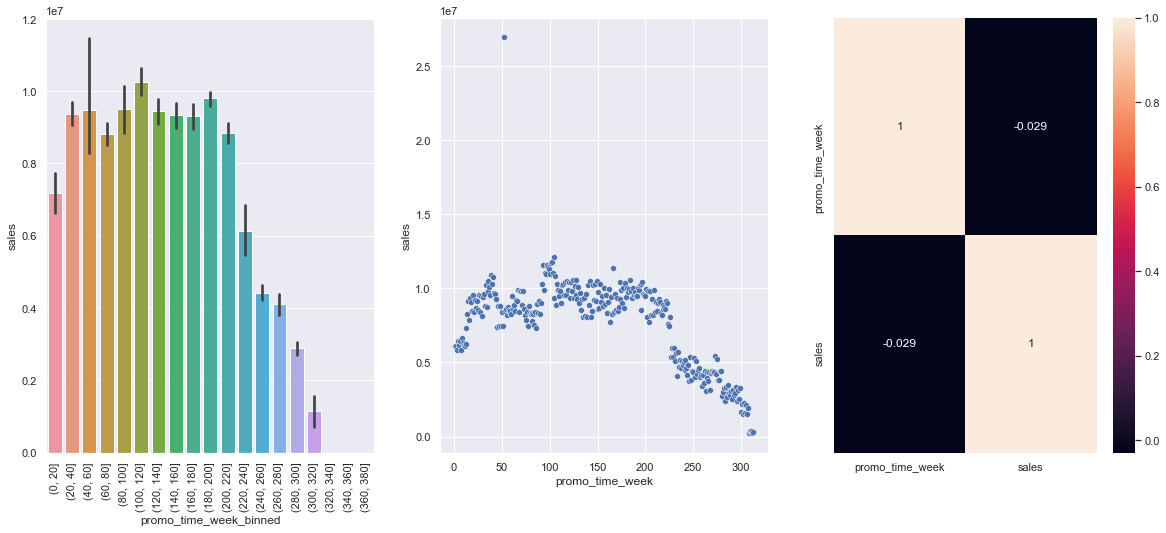

In [37]:
aux10 = df4[['sales', 'promo_time_week']].groupby('promo_time_week').sum().reset_index()

aux11 = aux10[aux10['promo_time_week'] > 0]

bins = list(np.arange(0, 400, 20))

aux11['promo_time_week_binned'] = pd.cut(aux10['promo_time_week'], bins=bins)

plt.subplot(1,3,1)

sns.barplot(x='promo_time_week_binned', y='sales', data=aux11);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.scatterplot(x='promo_time_week', y='sales', data=aux11);

plt.subplot(1,3,3)
sns.heatmap(aux10.corr(method='pearson'), annot=True);


### <s>H5. Lojas com mais dias em promocao deveriam vender mais</s>

### H6. Lojas com promocoes consecutivas deveriam vender mais
**FALSE**: Lojas com promocoes consecutivas vendem menos

In [38]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


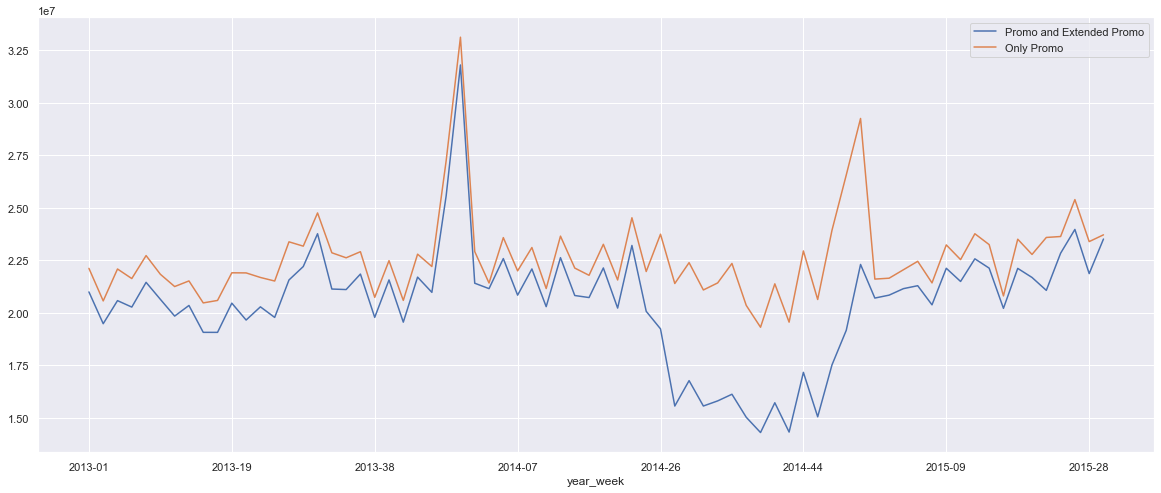

In [108]:
aux12 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
plot1 = aux12.plot(x='year_week', y='sales');

aux13 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux13.plot(ax=plot1);

plot1.legend(labels=['Promo and Extended Promo', 'Only Promo'])






### **H7.** Lojas abertas durante o feriado de Natal, deveriam vender mais
***FALSE***: Lojas abertas no feriado de Natal vendem menos

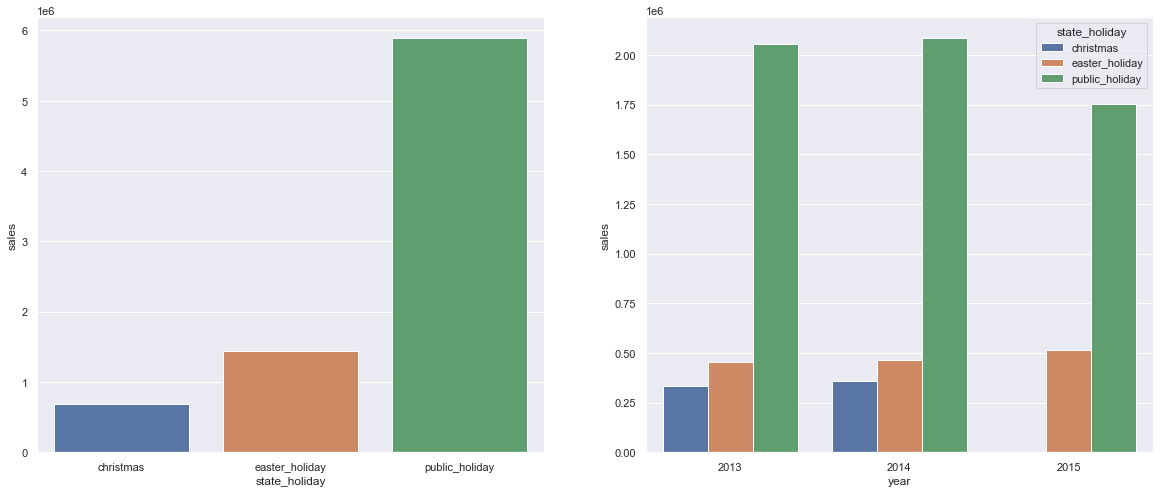

In [40]:
aux14 = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

aux15 = aux14[aux14['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)

sns.barplot(x='state_holiday', y='sales', data=aux15);

aux16 = df4[df4['state_holiday'] != 'regular_day'][['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()

plt.subplot(1,2,2)

sns.barplot(x='year', y='sales', hue='state_holiday', data=aux16);






### **H8.** Lojas deveriam vender mais ao longo dos anos
**FALSE**: Lojas vendem menos ao longo dos anos

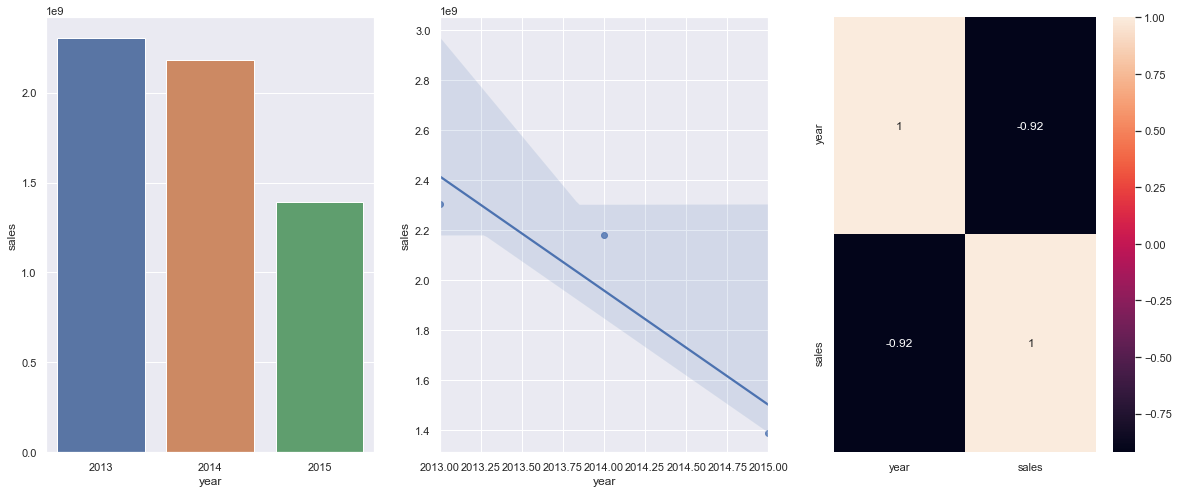

In [41]:
aux17 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)

sns.barplot(x='year', y='sales', data=aux17);

plt.subplot(1,3,2)

sns.regplot(x='year', y='sales', data=aux17);

plt.subplot(1,3,3)

sns.heatmap(aux17.corr(method='pearson'), annot=True);



### **H9.** Lojas deveriam vender mais no segundo semestre do ano
**FALSE**: Lojas vendem menos no segundo semestre dos anos


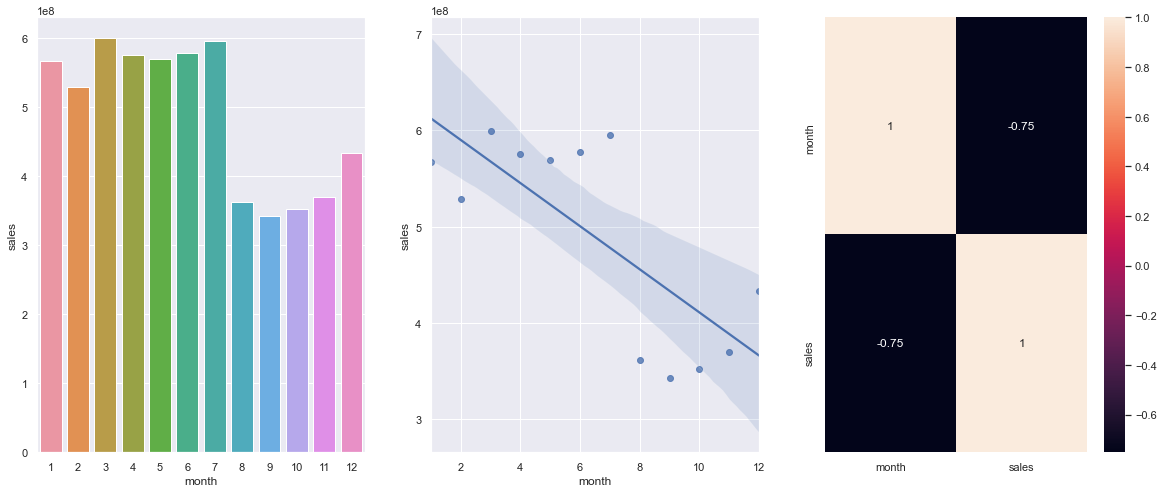

In [42]:
aux18 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)

sns.barplot(x='month', y='sales', data=aux18);

plt.subplot(1,3,2)

sns.regplot(x='month', y='sales', data=aux18);

plt.subplot(1,3,3)

sns.heatmap(aux18.corr(method='pearson'), annot=True);


### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mes
***TRUE***: Lojas vendem mais depois do dia 10 de cada mes



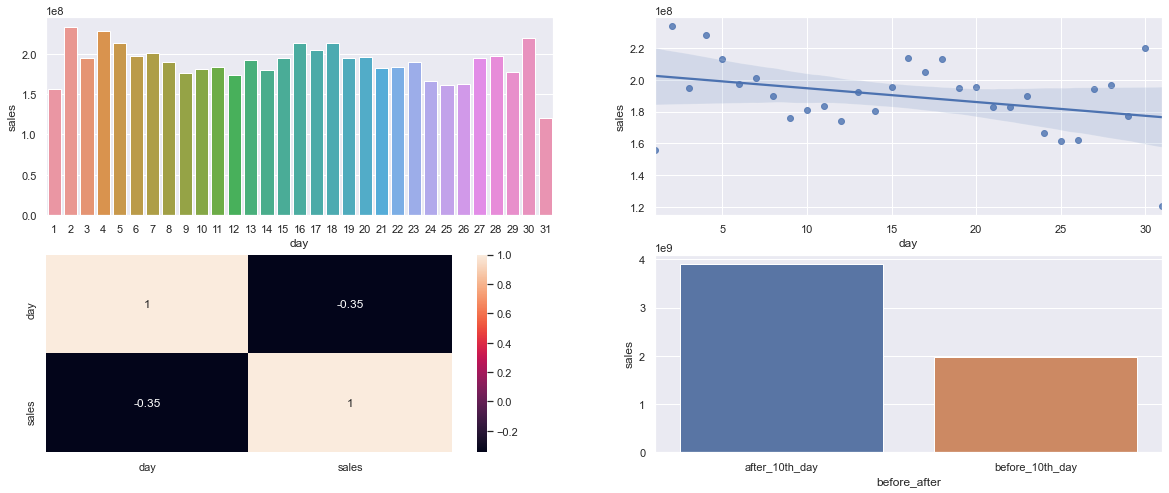

In [43]:
aux19 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)

sns.barplot(x='day', y='sales', data=aux19);

plt.subplot(2,2,2)

sns.regplot(x='day', y='sales', data=aux19);

plt.subplot(2,2,3)

sns.heatmap(aux19.corr(method='pearson'), annot=True);

aux19['before_after'] = aux19['day'].apply(lambda x: 'before_10th_day' if x <= 10 
                                                       else 'after_10th_day')

aux20 = aux19[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux20);

### **H11.** Lojas deveriam vender menos aos finais de semana
**TRUE**: Lojas vendem menos aos finais de semana



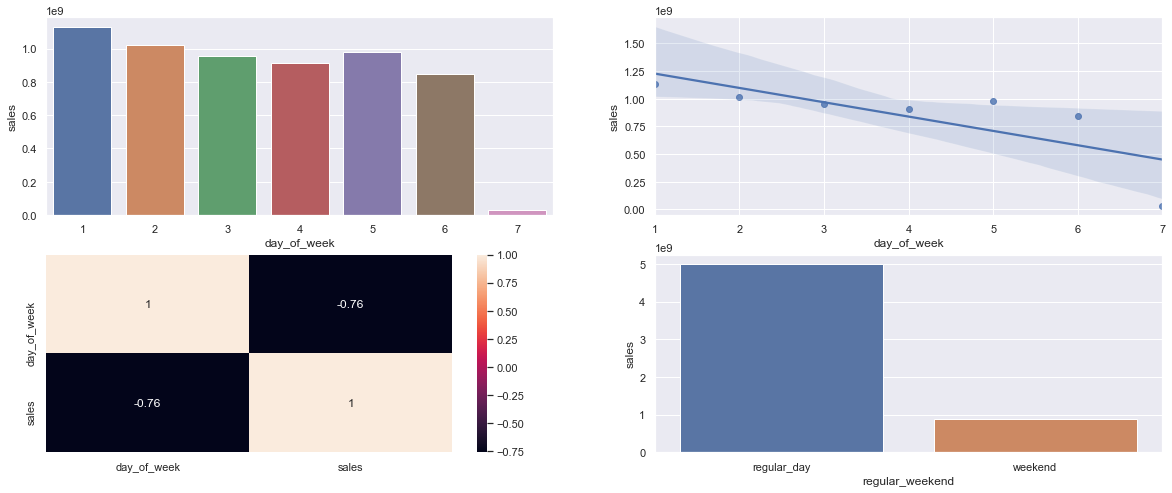

In [44]:
aux21 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,2,1)

sns.barplot(x='day_of_week', y='sales', data=aux21);

plt.subplot(2,2,2)

sns.regplot(x='day_of_week', y='sales', data=aux21);

plt.subplot(2,2,3)

sns.heatmap(aux21.corr(method='pearson'), annot=True);

aux21['regular_weekend'] = aux21['day_of_week'].apply(lambda x: 'regular_day' if x <= 5 
                                                       else 'weekend')

aux21 = aux21[['regular_weekend', 'sales']].groupby('regular_weekend').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='regular_weekend', y='sales', data=aux21);

### **H12.** Lojas deveriam vender menos durante os feriados escolares
**TRUE** Lojas vendem menos durante os feriados escolares, exceto mes de agosto.

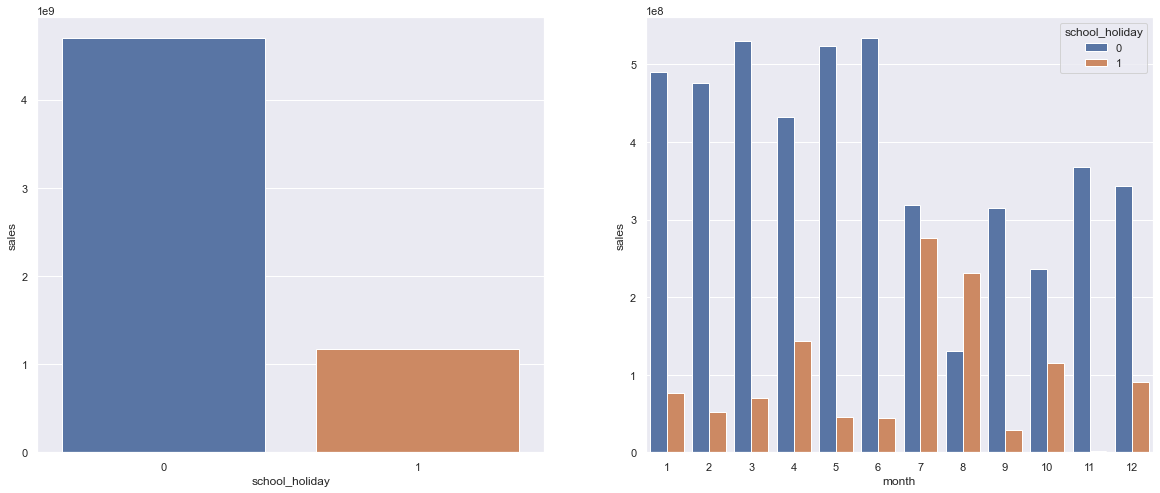

In [45]:
aux22 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1,2,1)

sns.barplot(x='school_holiday', y='sales', data=aux22);

plt.subplot(1,2,2)

aux23 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

sns.barplot(x='month', y='sales', hue='school_holiday', data=aux23);


### 4.2.1 Hypothesis Resume

In [46]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]

print(tabulate(tab, headers = 'firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Mutlivariate Analysis

### 4.3.1 Numerical Attributes

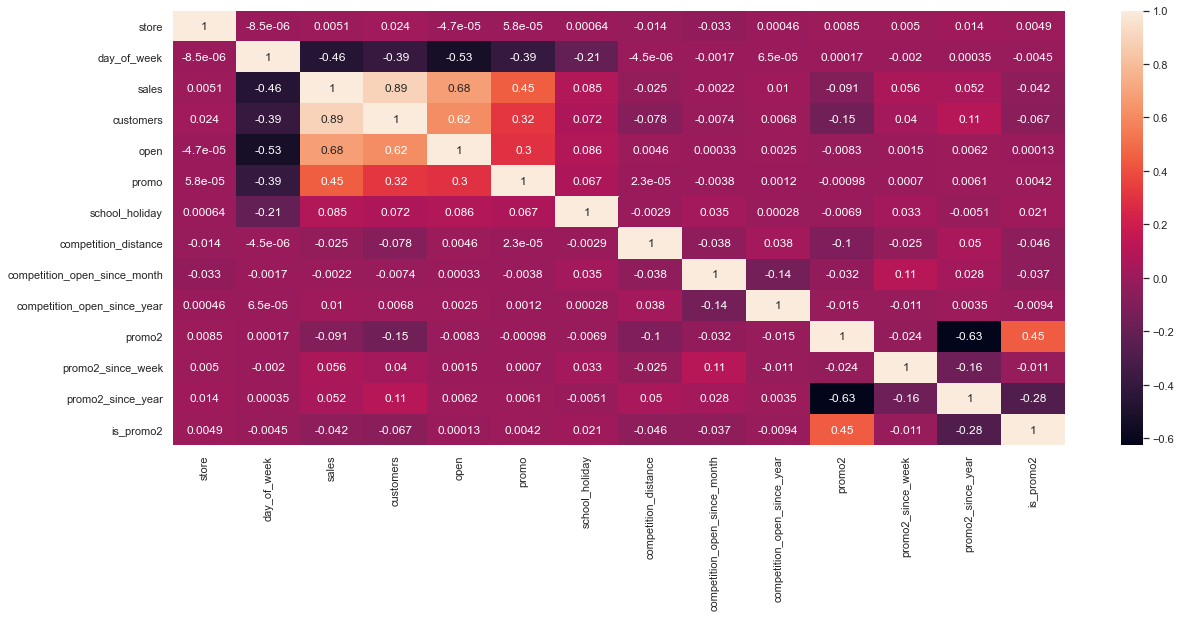

In [47]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1 Categorical Attributes

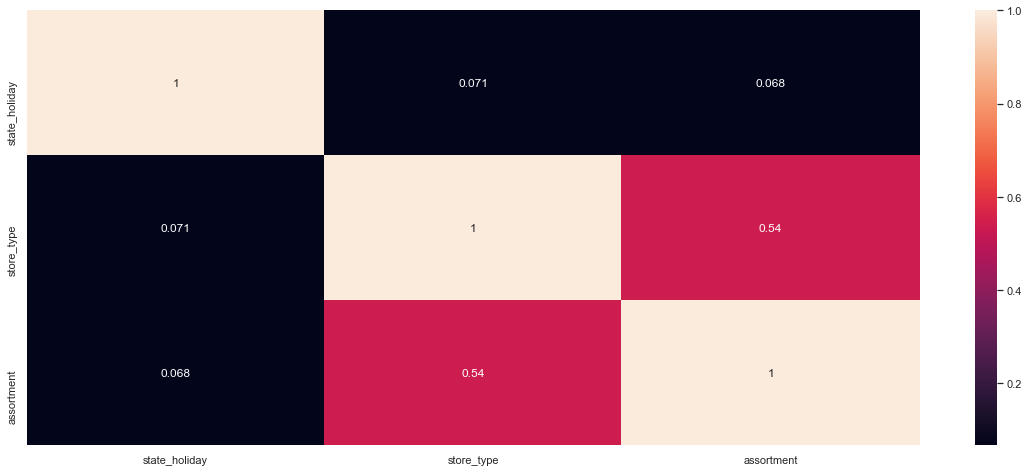

In [106]:
aux24 = df4.select_dtypes(include='object')

aux24.drop('year_week', axis=1)

vc1 = v_cramer(aux24['state_holiday'], aux24['state_holiday'])
vc2 = v_cramer(aux24['state_holiday'], aux24['store_type'])
vc3 = v_cramer(aux24['state_holiday'], aux24['assortment'])

vc4 = v_cramer(aux24['store_type'], aux24['state_holiday'])
vc5 = v_cramer(aux24['store_type'], aux24['store_type'])
vc6 = v_cramer(aux24['store_type'], aux24['assortment'])

vc7 = v_cramer(aux24['assortment'], aux24['state_holiday'])
vc8 = v_cramer(aux24['assortment'], aux24['store_type'])
vc9 = v_cramer(aux24['assortment'], aux24['assortment'])

correl = pd.DataFrame({'state_holiday': [vc1, vc2, vc3], 'store_type': [vc4, vc5, vc6], 'assortment': [vc7, vc8, vc9]})

correl = correl.set_index(correl.columns)

sns.heatmap(correl, annot=True);
